<a id="title_ID"></a>
# JWST Pipeline Validation Notebook: calwebb_detector1, NIRCam imaging

<span style="color:red"> **Instruments Affected**</span>: e.g., NIRCam 

### Table of Contents

<div style="text-align: left"> 
    
<br> [Introduction\*](#intro)
<br> [JWST CalWG Algorithm\*](#algorithm)
<br> [Defining Terms](#terms)
<br> [Test Description\*](#description)
<br> [Data Description\*](#data_descr)
<br> [Imports\*](#imports)
<br> [Convenience Functions](#convenience_functions)
<br> [Loading the Data\*](#download_data)
<br> [calwebb_detector1 - Ramps to slopes](#detector1) 
<br> [Run the entire pipeline](#detector1_at_once)
<br> [Run the individual pipeline steps](#detector1_step_by_step)
    <br> [The `Data Quality Initialization` step](#dq_init)
    <br> [The `Saturation Flagging` step](#saturation)
    <br> [The `Superbias Subtraction` step](#superbias)
    <br> [The `Reference Pixel Subtraction` step](#refpix)
    <br> [The `Linearity Correction` step](#linearity)
    <br> [The `Persistence Correction` step](#persistence)
    <br> [The `Dark Current Subtraction` step](#dc)
    <br> [The `Cosmic Ray Flagging` step](#jump)
    <br> [The `Ramp_Fitting` step](#ramp_fitting)
<br> [About This Notebook\*](#about)
<br>    

</div>

<a id='intro'></a>
# Introduction

This is the validation notebook for Stage 1 of the JWST calibration pipeline, also known as *calwebb_detector1*. The [Stage 1 pipeline](https://jwst-pipeline.readthedocs.io/en/stable/jwst/pipeline/calwebb_detector1.html#calwebb-detector1) applies basic detector-level corrections to all exposure types (imaging, spectroscopic, coronagraphic, etc.). It is applied to one exposure at a time, beginning with an uncalibrated multiaccum ramp (*_uncal.fits file*). It is sometimes referred to as “ramps-to-slopes” processing. The output is a corrected but uncalibrated countrate or slope image (*_rate.fits and _rateints.fits file*). 

Pipeline description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst

[Top of Page](#title_ID)

<a id="algorithm"></a>
# JWST CalWG Algorithm

This stage takes the raw images and returns the level 2a files, calibrated to slope (counts/sec) images.
The current status of the algorithms for this pipeline stage is summarized on the JWST CalWG algorithm Confluence page.  Links are provided to individual pages where the details of the algorithms are given along with notes on why those algorithms were picked.

The algorithms for each step in each pipeline stage are split into "baseline" and "enhanced" versions (formerly known as "vanilla" and "optimal", respectively).  See Baseline and Enhanced Algorithms for more details.
Input/Outputs of this stage refer to the main data products for the pipeline process. The full list of archive products for this (and all stages of the pipeline) is tabulated in Archive Products.

[JWST CalWG algorithms for calwebb_detector1](https://outerspace.stsci.edu/display/JWSTCC/CALWEBB_DETECTOR1)

[Top of Page](#title_ID)

<a id="terms"></a>
# Defining Terms


**JWST**: James Webb Space Telescope

**NIR**: Near Infrared


[Top of Page](#title_ID)

<a id="description"></a>
# Test Description

This test is performed by running simulated data through the full pipeline and performing a visual inspection of the outputs. Next, the notebook does quick checks after each step in the calwebb_detector1 pipeline, based on the algorithms defined. 


[Top of Page](#title_ID)

<a id="data_descr"></a>
# Data Description

For this module, we will use an uncalibrated NIRCam simulated imaging exposure generated with Mirage.


[Top of Page](#title_ID)

<a id="tempdir"></a>
# Set up Temporary Directory
The following cell sets up a temporary directory (using python's `tempfile.TemporaryDirectory()`), and changes the script's active directory into that directory (using python's `os.chdir()`). This is so that, when the notebook is run through, it will download files to (and create output files in) the temporary directory rather than in the notebook's directory. This makes cleanup significantly easier (since all output files are deleted when the notebook is shut down), and also means that different notebooks in the same directory won't interfere with each other when run by the automated webpage generation process.

If you want the notebook to generate output in the notebook's directory, simply don't run this cell.

If you have a file (or files) that are kept in the notebook's directory, and that the notebook needs to use while running, you can copy that file into the directory (the code to do so is present below, but commented out).

[Top of Page](#title_ID)

In [1]:
#****
#
# Set this variable to False to not use the temporary directory
#
#****
use_tempdir = True

# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
import shutil

if use_tempdir:
    data_dir = TemporaryDirectory()

    # If you have files that are in the notebook's directory, but that the notebook will need to use while
    # running, copy them into the temporary directory here.
    #
    # files = ['name_of_file']
    # for file_name in files:
    #     shutil.copy(file_name, os.path.join(data_dir.name, file_name))

    # Save original directory
    orig_dir = os.getcwd()

    # Move to new directory
    os.chdir(data_dir.name)

# For info, print out where the script is running
print("Running in {}".format(os.getcwd()))

Running in /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp2fosez3c


## If Desired, set up CRDS to use a local cache

By default, the notebook template environment sets up its CRDS cache (the "CRDS_PATH" environment variable) in /grp/crds/cache. However, if the notebook is running on a local machine without a fast and reliable connection to central storage, it makes more sense to put the CRDS cache locally. Currently, the cell below offers several options, and will check the supplied boolean variables one at a time until one matches.

* if `use_local_crds_cache` is False, then the CRDS cache will be kept in /grp/crds/cache
* if `use_local_crds_cache` is True, the CRDS cache will be kept locally
  * if `crds_cache_tempdir` is True, the CRDS cache will be kept in the temporary directory
  * if `crds_cache_notebook_dir` is True, the CRDS cache will be kept in the same directory as the notebook.
  * if `crds_cache_home` is True, the CRDS cache will be kept in $HOME/crds/cache
  * if `crds_cache_custom_dir` is True, the CRDS cache will be kept in whatever is stored in the 
    `crds_cache_dir_name` variable.

If the above cell (creating a temporary directory) is not run, then setting `crds_cache_tempdir` to True will store the CRDS cache in the notebook's directory (the same as setting `crds_cache_notebook_dir` to True).

In [2]:
import os
if 'CRDS_CACHE_TYPE' in os.environ:
    if os.environ['CRDS_CACHE_TYPE'] == 'local':
        os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'], 'crds', 'cache')
    elif os.path.isdir(os.environ['CRDS_CACHE_TYPE']):
        os.environ['CRDS_PATH'] = os.environ['CRDS_CACHE_TYPE']
print('CRDS cache location: {}'.format(os.environ['CRDS_PATH']))

CRDS cache location: /grp/crds/cache


<a id="imports"></a>
# Imports

In [3]:
# Packages that allow us to get information about objects:
import asdf
import copy
import os
import shutil

# Numpy library:
import numpy as np

# For downloading data
import requests

# Astropy tools:
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import ImageNormalize, ManualInterval, LogStretch

Set up matplotlib for plotting

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Use this version for non-interactive plots (easier scrolling of the notebook)
%matplotlib inline

# Use this version (outside of Jupyter Lab) if you want interactive plots
#%matplotlib notebook

# These gymnastics are needed to make the sizes of the figures
# be the same in both the inline and notebook versions
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

Import JWST pipeline-related modules

In [5]:
# List of possible data quality flags
from jwst.datamodels import dqflags

# The entire calwebb_detector1 pipeline
from jwst.pipeline import calwebb_detector1

# Individual steps that make up calwebb_detector1
from jwst.dq_init import DQInitStep
from jwst.saturation import SaturationStep
from jwst.superbias import SuperBiasStep
from jwst.ipc import IPCStep                                                                                    
from jwst.refpix import RefPixStep                                                                
from jwst.linearity import LinearityStep
from jwst.persistence import PersistenceStep
from jwst.dark_current import DarkCurrentStep
from jwst.jump import JumpStep
from jwst.ramp_fitting import RampFitStep
from jwst import datamodels

[Top of Page](#title_ID)

<a id='convenience_functions'></a>
# Define convenience functions and parameters

Here we define some functions and some parameters that we will use repeatedly throughout the notebook.

In [6]:
def plot_jump(signal, jump_group, xpixel=None, ypixel=None, slope=None):
    """Function to plot the signal up the ramp for a
    pixel and show the location of flagged jumps.
    
    Parameters
    ----------
    signal : numpy.ndarray
        1D array of signal values
        
    jump_group : list
        List of boolean values whether a jump is present or
        not in each group
        
    slope : numpy.ndarray
        1D array of signal values constructed from the slope
    """
    groups = np.arange(len(signal))
    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot()

    plt.plot(groups, signal, marker='o', color='black')
    plt.plot(groups[jump_group], signal[jump_group], marker='o', color='red',
             label='Flagged Jump')
    
    if slope is not None:
        plt.plot(groups, slope, marker='o', color='blue', label='Data from slope')
        
    plt.legend(loc=2)

    plt.xlabel('Groups')
    plt.ylabel('Signal (DN)')
    fig.tight_layout()
    plt.subplots_adjust(top=0.95)
    
    if xpixel and ypixel:
        plt.title('Pixel ('+str(xpixel)+','+str(ypixel)+')')

In [7]:
def plot_jumps(signals, jump_groups, pixel_loc, slopes=None):
    """Function to plot the ramp and show the jump location
    for several pixels. For simplicity, let's force the input
    number of pixels to be a square. 
    
    Parameters
    ----------
    signals : numpy.ndarray
        2D array (groups x pix) of signal values
        
    jump_groups : numpy.ndarray
        2D array containing boolean entries for each group of
        each pixel, describing where the jumps were found
        
    pixel_loc : list
        List of 2-tuples containing the (x, y)
        location of the pixels with the jumps
        
    slopes : numpy.ndarray
        2D array (groups x pix) of linear signal values
        If not None, these will be overplotted onto the
        plots of signals
    """
    num_group, num_pix = signals.shape
    root = np.sqrt(num_pix)
    if int(root + 0.5) ** 2 != num_pix:
        raise ValueError('Number of pixels input should be a square.')
    
    root = int(root)
    groups = np.arange(num_group)
    fig, axs = plt.subplots(root, root, figsize=(10, 10))

    for index in range(len(pixel_loc)):
        i = int(index % root)
        j = int(index / root)
        axs[i, j].plot(groups, signals[:, index], marker='o', color='black')
        j_grp = jump_groups[:, index]
        axs[i, j].plot(groups[j_grp], signals[j_grp, index],
                       marker='o', linestyle='None', color='red')
        
        if slopes is not None:
            axs[i, j].plot(groups, slopes[:, index], marker='o', color='blue')
        
        axs[i, j].set_title('Pixel ({}, {})'.format(pixel_loc[index][1], pixel_loc[index][0]))
        
    plt.xlabel('Groups')
    plt.ylabel('Signal (DN)')
    fig.tight_layout()

In [8]:
def plot_ramp(groups, signal, xpixel=None, ypixel=None, title=None):
    """Function to plot the up the ramp signal for a pixel.
    
    Parameters
    ----------
    groups : numpy.ndarray
        1D array of group numbers. X-axis values.
        
    signal : numpy.ndarray
        1D array of pixel signal values.
        
    xpixel : int
        X-coordinate of the pixel being plotted. Used for legend only.
        
    ypixel : int
        Y-coordinate of the pixel being plotted. Used for legend only.
        
    title : str
        String to use for the plot title
    """    
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot()
    if xpixel and ypixel:
            plt.plot(groups, signal, marker='o',
                     label='Pixel ('+str(xpixel)+','+str(ypixel)+')') 
            plt.legend(loc=2)

    else:
        plt.plot(groups, signal, marker='o')
        
    plt.xlabel('Groups')
    plt.ylabel('Signal (DN)')
    fig.tight_layout()
    plt.subplots_adjust(left=0.15)
    
    if title:
        plt.title(title)

In [9]:
def plot_ramps(groups, signal1, signal2, label1=None, label2=None, title=None):
    """Function to plot the up the ramp signal for two pixels
    on a single plot.
    
    Parameters
    ----------
    groups : numpy.ndarray
        1D array of group numbers. X-axis values.
        
    signal1 : numpy.ndarray
        1D array of signal values for first pixel
        
    signal2 : numpy.ndarray
        1D array of signal values for second pixel
        
    label1 : str
        Label to place in the legend for pixel1
        
    label2 : str
        Label to place in the legend for pixel2
        
    title : str
        String to place in the title of the plot
    """    
    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot()
    if label1:
        plt.plot(groups, signal1, marker='o', color='black', label=label1)
    else:
        plt.plot(groups, signal1, marker='o', color='black')
    if label2:
        plt.plot(groups, signal2, marker='o', color='red', label=label2)
    else:
        plt.plot(groups, signal2, marker='o', color='red')
    if label1 or label2:
        plt.legend(loc=2)
        
    plt.xlabel('Groups')
    plt.ylabel('Signal (DN)')
    fig.tight_layout()
    plt.subplots_adjust(left=0.15)
    plt.subplots_adjust(top=0.95)
    
    if title:
        plt.title(title)

In [10]:
def show_image(data_2d, vmin, vmax, xpixel=None, ypixel=None, title=None):
    """Function to generate a 2D, log-scaled image of the data, 
    with an option to highlight a specific pixel (with a red dot).
    
    Parameters
    ----------
    data_2d : numpy.ndarray
        Image to be displayed
        
    vmin : float
        Minimum signal value to use for scaling
        
    vmax : float
        Maximum signal value to use for scaling
        
    xpixel : int
        X-coordinate of pixel to highlight
        
    ypixel : int
        Y-coordinate of pixel to highlight
        
    title : str
        String to use for the plot title
    """
    norm = ImageNormalize(data_2d, interval=ManualInterval(vmin=vmin, vmax=vmax),
                          stretch=LogStretch())
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    im = ax.imshow(data_2d, origin='lower', norm=norm)
    
    if xpixel and ypixel:
        plt.plot(xpixel, ypixel, marker='o', color='red', label='Selected Pixel')

    fig.colorbar(im, label='DN')
    plt.xlabel('Pixel column')
    plt.ylabel('Pixel row')
    if title:
        plt.title(title)

In [11]:
def side_by_side(data1, data2, vmin, vmax, title1=None, title2=None, title=None):
    """Show two images side by side for easy comparison. Optionally highlight
    a given pixel with a red dot.
    
    Parameters
    ----------
    data1 : numpy.ndarray
        First image to be displayed
        
    data2 : numpy.ndarray
        Second image to be displayed
        
    vmin : float
        Minimum signal value to use for scaling
        
    vmax : float
        Maximum signal value to use for scaling
            
    title1 : str
        Title to use for first (left) plot
        
    title2 : str
        Title to use for the second (right) plot

    title : str
        String to use for the plot title
    """
    norm = ImageNormalize(data1, interval=ManualInterval(vmin=vmin, vmax=vmax),
                          stretch=LogStretch())

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 8))
    im = axes[0].imshow(data1, origin='lower', norm=norm)
    im = axes[1].imshow(data2, origin='lower', norm=norm)
    
    axes[0].set_xlabel('Pixel column')
    axes[0].set_ylabel('Pixel row')
    axes[1].set_xlabel('Pixel column')
    
    if title1:
        axes[0].set_title(title1)
    if title2:
        axes[1].set_title(title2)
        
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax, label='DN')
    
    if title:
        fig.suptitle(title)    

[Top of Page](#title_ID)

<a id="data_load"></a>
# Loading the Data

In [12]:
from astropy.utils.data import download_file
from pathlib import Path
from shutil import move
from os.path import splitext

def get_box_files(file_list):
    for box_url,file_name in file_list:
        if 'https' not in box_url:
            box_url = 'https://stsci.box.com/shared/static/' + box_url
        downloaded_file = download_file(box_url, timeout=600)
        if Path(file_name).suffix == '':
            ext = splitext(box_url)[1]
            file_name += ext
        move(downloaded_file, file_name)
        
file_urls = ['https://stsci.box.com/shared/static/j46wpyirlbqo30e7c9719ycnuc1qk2lu.fits']

file_names = ['jw98765001001_01101_00003_nrcb5_uncal.fits']        

box_download_list = [(url,name) for url,name in zip(file_urls,file_names)]

In [13]:
get_box_files(box_download_list)

[Top of Page](#title_ID)

---
<a id='detector1'></a>
# The calwebb_detector1 pipeline: Ramps to slopes

In the sections below, we will run the Stage 1 pipeline on a single uncalibrated NIRCam file. We will first call the entire [*calwebb_detector1* pipeline](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html#calwebb-detector1) on the file. The pipeline is a wrapper which will string together all of the appropriate steps in the proper order. 

The final output from this call is an uncalibrated slope image which is ready to go into the Stage 2 pipeline. "Uncalibrated" in this case means that the data are in units of DN/sec. 

After that, we will go back to the original uncalibrated ramp and manually run it through each of the steps that comprise the Stage 1 pipeline. For each step we will examine the output.

See [Figure 1](https://jwst-docs.stsci.edu/jwst-data-reduction-pipeline/stages-of-processing/calwebb_detector1) on the calwebb_detector1 algorithm page for a map of which steps are performed on NIR data.

<a id='detector1_at_once'></a>
# Run the entire `calwebb_detecor1` pipeline

In this section we run the entire calwebb_detector1 pipeline with a single call. In this case the pipeline code can determine which instrument was used to collect the data and runs the appropriate steps in the proper order.

We set parameter values for some of the individual steps, save some outputs, etc, and then call the pipeline.

In [14]:
# Create an instance of the pipeline class
detector1 = calwebb_detector1.Detector1Pipeline()

# Set some parameters that pertain to the
# entire pipeline
detector1.save_results = True

# Set some parameters that pertain to some of
# the individual steps
detector1.refpix.use_side_ref_pixels = True
detector1.refpix.odd_even_rows = False

# Save outputs from steps to examine
detector1.dq_init.save_results = True
detector1.saturation.save_results = True
detector1.superbias.save_results = True
detector1.refpix.save_results = True
detector1.linearity.save_results = True
detector1.dark_current.save_results = True
detector1.persistence.save_results = True
detector1.jump.save_results = True
detector1.ramp_fit.save_opt = True
detector1.ramp_fit.save_results = True

2022-07-06 09:43:26,147 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-07-06 09:43:26,150 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-07-06 09:43:26,152 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-07-06 09:43:26,154 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-07-06 09:43:26,155 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-07-06 09:43:26,157 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-07-06 09:43:26,298 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-07-06 09:43:26,301 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-07-06 09:43:26,305 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-07-06 09:43:26,306 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-07-06 09:43:26,308 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-07-06 09:43:26,309 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-07-06 09:43:26,311 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-07-06 09:43:26,312 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-07-06 09:43:26,314 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-07-06 09:43:26,315 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-07-06 09:43:26,317 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


In [15]:
# Call the run() method
run_output = detector1.run(file_names[0])

2022-07-06 09:43:26,419 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('jw98765001001_01101_00003_nrcb5_uncal.fits',).


2022-07-06 09:43:26,438 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output

2022-07-06 09:43:27,773 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw98765001001_01101_00003_nrcb5_uncal.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-07-06 09:43:29,575 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_nircam_dark_0048.fits'.


2022-07-06 09:43:29,578 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_nircam_gain_0054.fits'.


2022-07-06 09:43:29,580 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/grp/crds/cache/references/jwst/jwst_nircam_ipc_0023.fits'.


2022-07-06 09:43:29,583 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_nircam_linearity_0049.fits'.


2022-07-06 09:43:29,585 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_nircam_mask_0065.fits'.


2022-07-06 09:43:29,587 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is '/grp/crds/cache/references/jwst/jwst_nircam_persat_0023.fits'.


2022-07-06 09:43:29,589 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_nircam_readnoise_0091.fits'.


2022-07-06 09:43:29,591 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2022-07-06 09:43:29,592 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-07-06 09:43:29,593 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2022-07-06 09:43:29,594 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_nircam_saturation_0092.fits'.


2022-07-06 09:43:29,596 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_nircam_superbias_0074.fits'.


2022-07-06 09:43:29,598 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is '/grp/crds/cache/references/jwst/jwst_nircam_trapdensity_0003.fits'.


2022-07-06 09:43:29,600 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is '/grp/crds/cache/references/jwst/jwst_nircam_trappars_0006.fits'.


2022-07-06 09:43:29,603 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-07-06 09:43:30,089 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 10, 2048, 2048) from jw98765001001_01101_00003_nrcb5_uncal.fits>,).


2022-07-06 09:43:30,091 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-07-06 09:43:30,293 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-07-06 09:43:30,295 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-07-06 09:43:30,298 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-07-06 09:43:30,428 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 10, 2048, 2048) from jw98765001001_01101_00003_nrcb5_uncal.fits>,).


2022-07-06 09:43:30,430 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-07-06 09:43:30,453 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_nircam_mask_0065.fits


2022-07-06 09:43:31,657 - stpipe.Detector1Pipeline.dq_init - INFO - Saved model in jw98765001001_01101_00003_nrcb5_dq_init.fits


2022-07-06 09:43:31,658 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-07-06 09:43:31,774 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 10, 2048, 2048) from jw98765001001_01101_00003_nrcb5_dq_init.fits>,).


2022-07-06 09:43:31,776 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-07-06 09:43:31,799 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_nircam_saturation_0092.fits


2022-07-06 09:43:34,844 - stpipe.Detector1Pipeline.saturation - INFO - Detected 42339 saturated pixels


2022-07-06 09:43:34,895 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-07-06 09:43:35,303 - stpipe.Detector1Pipeline.saturation - INFO - Saved model in jw98765001001_01101_00003_nrcb5_saturation.fits


2022-07-06 09:43:35,304 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-07-06 09:43:35,430 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 10, 2048, 2048) from jw98765001001_01101_00003_nrcb5_saturation.fits>,).


2022-07-06 09:43:35,433 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-07-06 09:43:35,458 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file /grp/crds/cache/references/jwst/jwst_nircam_ipc_0023.fits


2022-07-06 09:43:36,639 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-07-06 09:43:36,770 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 10, 2048, 2048) from jw98765001001_01101_00003_nrcb5_saturation.fits>,).


2022-07-06 09:43:36,772 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-07-06 09:43:36,797 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /grp/crds/cache/references/jwst/jwst_nircam_superbias_0074.fits


2022-07-06 09:43:37,694 - stpipe.Detector1Pipeline.superbias - INFO - Saved model in jw98765001001_01101_00003_nrcb5_superbias.fits


2022-07-06 09:43:37,696 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2022-07-06 09:43:37,819 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 10, 2048, 2048) from jw98765001001_01101_00003_nrcb5_superbias.fits>,).


2022-07-06 09:43:37,821 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2022-07-06 09:43:38,019 - stpipe.Detector1Pipeline.refpix - INFO - NIR full frame data


2022-07-06 09:43:38,021 - stpipe.Detector1Pipeline.refpix - INFO - The following parameters are valid for this mode:


2022-07-06 09:43:38,022 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


2022-07-06 09:43:38,023 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


2022-07-06 09:43:38,024 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


2022-07-06 09:43:38,025 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.0


2022-07-06 09:43:38,026 - stpipe.Detector1Pipeline.refpix - INFO - The following parameter is not applicable and is ignored:


2022-07-06 09:43:38,027 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = False


2022-07-06 09:43:41,868 - stpipe.Detector1Pipeline.refpix - INFO - Saved model in jw98765001001_01101_00003_nrcb5_refpix.fits


2022-07-06 09:43:41,870 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-07-06 09:43:42,002 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 10, 2048, 2048) from jw98765001001_01101_00003_nrcb5_refpix.fits>,).


2022-07-06 09:43:42,004 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-07-06 09:43:42,030 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_nircam_linearity_0049.fits


2022-07-06 09:43:43,209 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_DO_NOT_USE does not correspond to an existing DQ mnemonic, so will be ignored


2022-07-06 09:43:43,210 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_NO_LIN_SAMP does not correspond to an existing DQ mnemonic, so will be ignored


2022-07-06 09:43:43,211 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_BAD_LIN_FIT does not correspond to an existing DQ mnemonic, so will be ignored


2022-07-06 09:43:43,212 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_NO_WELL_SAMP does not correspond to an existing DQ mnemonic, so will be ignored


2022-07-06 09:43:43,213 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_MODEL_FIT_FAIL does not correspond to an existing DQ mnemonic, so will be ignored


2022-07-06 09:43:43,216 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_WELL_NOT_DEFINED does not correspond to an existing DQ mnemonic, so will be ignored


2022-07-06 09:43:43,217 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_MASTER_MASK does not correspond to an existing DQ mnemonic, so will be ignored


2022-07-06 09:43:44,784 - stpipe.Detector1Pipeline.linearity - INFO - Saved model in jw98765001001_01101_00003_nrcb5_linearity.fits


2022-07-06 09:43:44,785 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-07-06 09:43:45,000 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence running with args (<RampModel(1, 10, 2048, 2048) from jw98765001001_01101_00003_nrcb5_linearity.fits>,).


2022-07-06 09:43:45,002 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'input_trapsfilled': '', 'flag_pers_cutoff': 40.0, 'save_persistence': False, 'save_trapsfilled': True}


2022-07-06 09:43:45,905 - stpipe.Detector1Pipeline.persistence - WARNING - Keyword WEIRD does not correspond to an existing DQ mnemonic, so will be ignored


2022-07-06 09:43:49,892 - stpipe.Detector1Pipeline.persistence - INFO - Saved model in jw98765001001_01101_00003_nrcb5_trapsfilled.fits


2022-07-06 09:43:50,394 - stpipe.Detector1Pipeline.persistence - INFO - Saved model in jw98765001001_01101_00003_nrcb5_persistence.fits


2022-07-06 09:43:50,396 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence done


2022-07-06 09:43:50,540 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 10, 2048, 2048) from jw98765001001_01101_00003_nrcb5_persistence.fits>,).


2022-07-06 09:43:50,542 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-07-06 09:43:50,567 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_nircam_dark_0048.fits


2022-07-06 09:44:17,702 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword HIGH_NOISE does not correspond to an existing DQ mnemonic, so will be ignored


2022-07-06 09:44:17,703 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNSTABLE_NOISE does not correspond to an existing DQ mnemonic, so will be ignored


2022-07-06 09:44:17,708 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=10, nframes=1, groupgap=1


2022-07-06 09:44:17,709 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=108, nframes=1, groupgap=0


2022-07-06 09:44:19,351 - stpipe.Detector1Pipeline.dark_current - INFO - Saved model in jw98765001001_01101_00003_nrcb5_dark_current.fits


2022-07-06 09:44:19,352 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-07-06 09:44:19,574 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 10, 2048, 2048) from jw98765001001_01101_00003_nrcb5_dark_current.fits>,).


2022-07-06 09:44:19,576 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2022-07-06 09:44:19,587 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-07-06 09:44:19,602 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nircam_gain_0054.fits


2022-07-06 09:44:19,779 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nircam_readnoise_0091.fits


2022-07-06 09:44:20,283 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-07-06 09:44:20,376 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-07-06 09:44:23,908 - stpipe.Detector1Pipeline.jump - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.10/site-packages/stcal/jump/twopoint_difference.py:128: RuntimeWarning: All-NaN slice encountered
  max_ratio = np.nanmax(ratio, axis=0)



2022-07-06 09:44:24,091 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 47080 pixels with at least one CR from five groups.


2022-07-06 09:44:24,093 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7 pixels with at least one CR from four groups.


2022-07-06 09:44:24,094 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10 pixels with at least one CR from three groups.


2022-07-06 09:44:32,776 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 12.4913 sec


2022-07-06 09:44:32,787 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 13.199829


2022-07-06 09:44:33,199 - stpipe.Detector1Pipeline.jump - INFO - Saved model in jw98765001001_01101_00003_nrcb5_jump.fits


2022-07-06 09:44:33,201 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-07-06 09:44:33,481 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 10, 2048, 2048) from jw98765001001_01101_00003_nrcb5_jump.fits>,).


2022-07-06 09:44:33,483 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': True, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-07-06 09:44:33,529 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nircam_readnoise_0091.fits


2022-07-06 09:44:33,530 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nircam_gain_0054.fits


2022-07-06 09:44:33,617 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-07-06 09:44:33,619 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-07-06 09:45:28,143 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1195: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)



2022-07-06 09:45:31,878 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 10


2022-07-06 09:45:31,880 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 1


2022-07-06 09:45:32,678 - stpipe.Detector1Pipeline.ramp_fit - INFO - Saved model in jw98765001001_01101_00003_nrcb5_fitopt.fits


2022-07-06 09:45:32,903 - stpipe.Detector1Pipeline.ramp_fit - INFO - Saved model in jw98765001001_01101_00003_nrcb5_0_ramp_fit.fits


2022-07-06 09:45:33,036 - stpipe.Detector1Pipeline.ramp_fit - INFO - Saved model in jw98765001001_01101_00003_nrcb5_1_ramp_fit.fits


2022-07-06 09:45:33,038 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-07-06 09:45:33,227 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(2048, 2048) from jw98765001001_01101_00003_nrcb5_0_ramp_fit.fits>,).


2022-07-06 09:45:33,229 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-07-06 09:45:33,292 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-07-06 09:45:33,294 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-07-06 09:45:33,299 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-07-06 09:45:33,426 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 2048) from jw98765001001_01101_00003_nrcb5_1_ramp_fit.fits>,).


2022-07-06 09:45:33,428 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-07-06 09:45:33,491 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-07-06 09:45:33,492 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-07-06 09:45:33,497 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-07-06 09:45:33,629 - stpipe.Detector1Pipeline - INFO - Saved model in jw98765001001_01101_00003_nrcb5_rateints.fits


2022-07-06 09:45:33,631 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-07-06 09:45:33,631 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0913.pmap


2022-07-06 09:45:33,758 - stpipe.Detector1Pipeline - INFO - Saved model in jw98765001001_01101_00003_nrcb5_rate.fits


2022-07-06 09:45:33,759 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


### Examine the outputs

The primary output of the calwebb_detector1 pipeline is a file containing a rate image for the exposure. The units of the data are ADU/sec.  

In [16]:
# Generate the rate file name from the uncal file name
rate_file = file_names[0].replace('uncal.fits', 'rate.fits')

In [17]:
rate_file

'jw98765001001_01101_00003_nrcb5_rate.fits'

In [18]:
# Use getdata to quickly read in the science data from the rate file
rate_data = fits.getdata(rate_file)

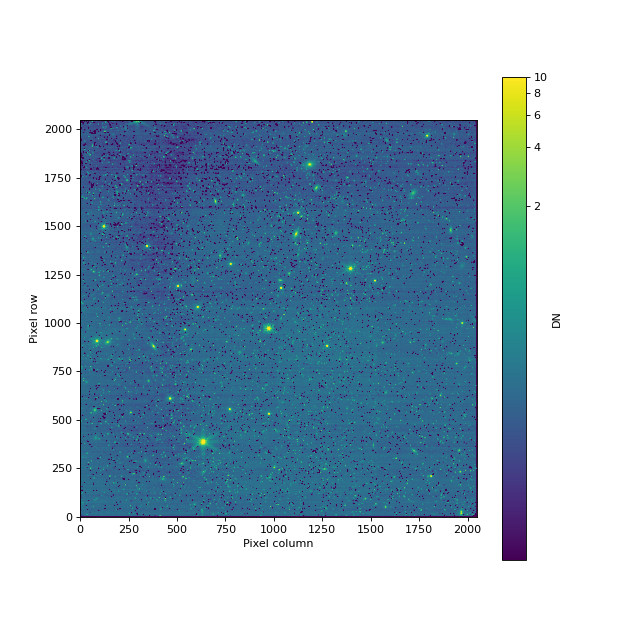

In [19]:
# Look at the rate image
show_image(rate_data, 0.5, 10)

In [20]:
# Generate the linear step file name from the uncal file name
linear_file = rate_file.replace('rate.fits', 'linearity.fits')

In [21]:
# Read in the science data from the linear file
lin_data = fits.getdata(linear_file)

We will look in more detail at the effects of the linearity correction step in the [linearity](#linearity) section below. For now, let's just look at the final group of the integration.

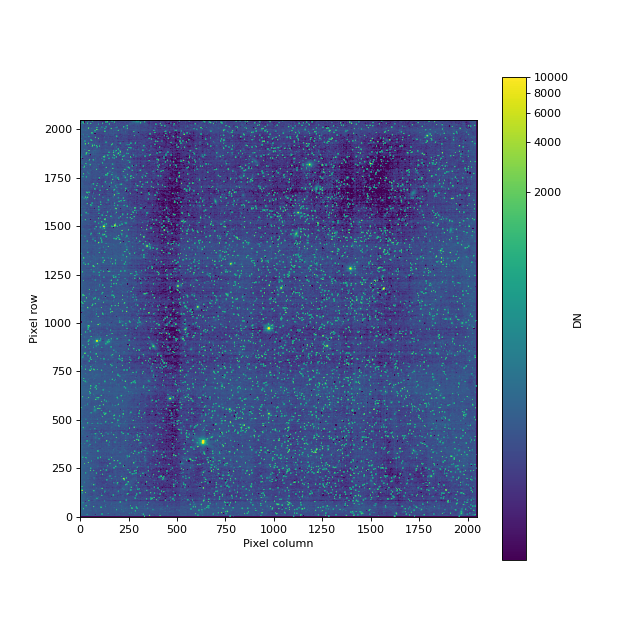

In [22]:
# Let's look at the data in the final group of the linearized data:
show_image(lin_data[0, -1, :, :], 100, 10000)

[Top of Page](#title_ID)

<a id='detector1_step_by_step'></a>
# Run the individual pipeline steps

In the sections below we run the steps contained within calwebb_detector1 one at a time, in order to check the outputs for each step.

<a id='dq_init'></a>
### The `Data Quality Initialization` step

#### Summary

This step populates the Data Quality (DQ) mask that is associated with the data file. The DQ flags from the `MASK` reference file are copied into the `PIXELDQ` extension of the input file. A table showing the [mapping of bit values](https://jwst-pipeline.readthedocs.io/en/stable/jwst/references_general/references_general.html#data-quality-flags) in the `MASK` file decribes what types of bad pixels can be flagged. Any other bad pixel types will be ignored.

#### Documentation

[Full description](https://jwst-pipeline.readthedocs.io/en/stable/jwst/dq_init/description.html) of the step.

#### Arguments

There are no optional arguments for this step

#### Reference files used

This step uses the `MASK` reference file. 


#### Run the step

Since we ran the step above and saved the outputs, we'll skip this part and just load the outputs. 

In [23]:
# # Using the run() method. Instantiate and set parameters
# dq_init_step = DQInitStep()
# dq_init_step.save_results = True

# # Call the run() method on the uncal file
# dq_init = dq_init_step.run(file_names[0])

In [24]:
#with datamodels.open(file_names[0].replace('uncal.fits', 'dq_init.fits')) as dq_init:
dq_init = datamodels.open(file_names[0].replace('uncal.fits', 'dq_init.fits'))
print(dq_init.info())

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 2.12.0
├─history (dict)
│ └─extensions (list) ...
├─_fits_hash (str): 1cbc7bd54d5fe3a8112a62465c36ce0a5fd4de4f42b18014ebd8dbf1068f520c
├─data (ndarray): shape=(1, 10, 2048, 2048), dtype=float32
├─err (ndarray): shape=(1, 10, 2048, 2048), dtype=float32
├─extra_fits (dict)
│ └─PRIMARY (dict) ...
├─group (FITS_rec): shape=(10,), dtype=record784
├─groupdq (ndarray): shape=(1, 10, 2048, 2048), dtype=uint8
├─int_times (FITS_rec): shape=(1,), dtype=record416
├─meta (dict)
│ ├─aperture (dict) ...
│ ├─cal_step (dict) ...
│ ├─calibration_software_revision (str): RELEASE
│ └─19 not shown
├─pixeldq (ndarray): shape=(2048, 2048), dtype=uint32
└─zeroframe (ndarray): shape=(1, 2048, 2048), dtype=float32
Some nodes not shown.
None


In [25]:
# Print the list of JWST bad pixel types
dqflags.pixel

{'GOOD': 0,
 'DO_NOT_USE': 1,
 'SATURATED': 2,
 'JUMP_DET': 4,
 'DROPOUT': 8,
 'OUTLIER': 16,
 'PERSISTENCE': 32,
 'AD_FLOOR': 64,
 'RESERVED_4': 128,
 'UNRELIABLE_ERROR': 256,
 'NON_SCIENCE': 512,
 'DEAD': 1024,
 'HOT': 2048,
 'WARM': 4096,
 'LOW_QE': 8192,
 'RC': 16384,
 'TELEGRAPH': 32768,
 'NONLINEAR': 65536,
 'BAD_REF_PIXEL': 131072,
 'NO_FLAT_FIELD': 262144,
 'NO_GAIN_VALUE': 524288,
 'NO_LIN_CORR': 1048576,
 'NO_SAT_CHECK': 2097152,
 'UNRELIABLE_BIAS': 4194304,
 'UNRELIABLE_DARK': 8388608,
 'UNRELIABLE_SLOPE': 16777216,
 'UNRELIABLE_FLAT': 33554432,
 'OPEN': 67108864,
 'ADJ_OPEN': 134217728,
 'UNRELIABLE_RESET': 268435456,
 'MSA_FAILED_OPEN': 536870912,
 'OTHER_BAD_PIXEL': 1073741824,
 'REFERENCE_PIXEL': 2147483648}

The pixel values in the `SCI` extension are not changed in this step. Instead, the DQ flags are copied into the `PIXELDQ` extension. The `GROUPDQ` values are not changed in this step. Let's check the `PIXELDQ` values and see what has changed.

In [26]:
# Print some basic information on the number of flagged pixels
idx_pixelDQ = np.where(dq_init.pixeldq.flatten() == 0.)[0]
num_flagged = dq_init.pixeldq.size - len(idx_pixelDQ)
print('Total pixels in PIXELDQ: {}'.format(dq_init.pixeldq.size))
print('{} pixels have no flags.'.format(len(idx_pixelDQ)))
print('{} pixels ({:.2f}% of the detector) have flags.'.format(num_flagged, num_flagged / dq_init.pixeldq.size))

Total pixels in PIXELDQ: 4194304
4148514 pixels have no flags.
45790 pixels (0.01% of the detector) have flags.


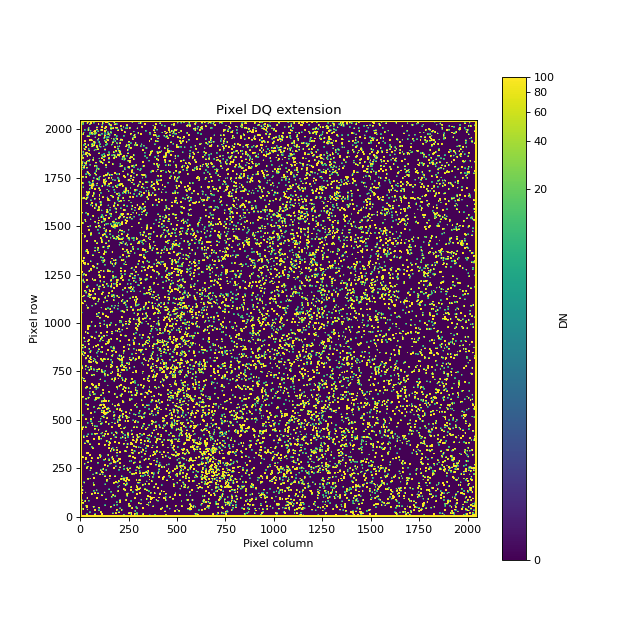

In [27]:
show_image(dq_init.pixeldq, 0, 100, title='Pixel DQ extension')

In [28]:
(unique, counts) = np.unique(dq_init.pixeldq, return_counts=True)
frequencies = np.asarray((unique, counts)).T

In [29]:
print('Number of counts for each flag: ')
print(frequencies)

Number of counts for each flag: 
[[         0    4148514]
 [      1025       4694]
 [      2049        767]
 [     16385       5874]
 [     32769       1751]
 [2147483648      32704]]


[Top of Page](#title_ID)

<a id='saturation'></a>
## The `Saturation Flagging` step

#### Summary

This step checks the signal values in all pixels across all groups, and adds a [`saturated` flag](https://jwst-pipeline.readthedocs.io/en/stable/jwst/references_general/references_general.html#data-quality-flags) to the `GROUPDQ` extension for pixels and groups where the signal is above the saturation limit.

#### Documentation

[Full description](https://jwst-pipeline.readthedocs.io/en/stable/jwst/saturation/description.html) of the step.

#### Arguments

There are no optional arguments for this step

#### Reference files used

This step uses the [`SATURATION`](https://jwst-pipeline.readthedocs.io/en/stable/jwst/saturation/reference_files.html) reference file. This file contains a map of the saturation threshold in ADU for each pixel on the detector.

#### Run the step

Since we ran the step above and saved the outputs, we'll skip this part and just load the outputs. 

In [30]:
# # Using the run() method
# saturation_step = SaturationStep()
# saturation_step.output_dir = output_dir
# saturation_step.save_results = True

# # Call using the the output from the previously-run dq_init step
# saturation = saturation_step.run(dq_init)

In [31]:
#with datamodels.open(file_names[0].replace('uncal.fits', 'saturation.fits')) as saturation:
saturation = datamodels.open(file_names[0].replace('uncal.fits', 'saturation.fits'))   
print(saturation.info())

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 2.12.0
├─history (dict)
│ └─extensions (list) ...
├─_fits_hash (str): 106778171577eb92b26f7b287204b95969da3c75e3c3d40dd166854fbcf28a50
├─data (ndarray): shape=(1, 10, 2048, 2048), dtype=float32
├─err (ndarray): shape=(1, 10, 2048, 2048), dtype=float32
├─extra_fits (dict)
│ └─PRIMARY (dict) ...
├─group (FITS_rec): shape=(10,), dtype=record784
├─groupdq (ndarray): shape=(1, 10, 2048, 2048), dtype=uint8
├─int_times (FITS_rec): shape=(1,), dtype=record416
├─meta (dict)
│ ├─aperture (dict) ...
│ ├─cal_step (dict) ...
│ ├─calibration_software_revision (str): RELEASE
│ └─19 not shown
├─pixeldq (ndarray): shape=(2048, 2048), dtype=uint32
└─zeroframe (ndarray): shape=(1, 2048, 2048), dtype=float32
Some nodes not shown.
None


If there are any saturated values, they should appear in the `GROUPDQ` arrays. Let's examine the `GROUPDQ` data and see if there are any detected:

In [32]:
# Find indexes of saturated pixels
saturated = np.where(saturation.groupdq & dqflags.pixel['SATURATED'] > 0)

In [33]:
num_sat_flags = len(saturated[0])
print(('Found {} saturated flags. This may include multiple saturated '
       'groups within a given pixel'.format(num_sat_flags)))

Found 415721 saturated flags. This may include multiple saturated groups within a given pixel


Let's find a pixel that saturated part of the way up the ramp.

In [34]:
# Create a 4D boolean map of whether the saturation flag is present or not.
saturated = (saturation.groupdq & dqflags.pixel['SATURATED'] > 0)

In [35]:
# Collapse that down to a 2D map that lists the number of saturated groups 
# for each pixel.
saturated_2d = np.sum(saturated[0, :, :, :], axis=0)

In [36]:
# Get coordinates of pixels that are saturated in some, but not all, groups.
partial_sat = np.where((saturated_2d > 0) & (saturated_2d < saturated.shape[1]))
print("{} pixels are partially saturated.".format(len(partial_sat[0])))

1988 pixels are partially saturated.


Now let's choose one of these partially saturated pixels and look at the signal values up the ramp, along with which groups are flagged as saturated.

In [37]:
sat_y, sat_x = partial_sat
sat_index = 123
y = sat_y[sat_index]
x = sat_x[sat_index]
grps = saturated[0, :, y, x]
print('Saturation flags up the ramp (0 is not saturated, 2 is saturated): {}'
      .format(saturation.groupdq[0, :, y, x]))
print('Pixel signal values up the ramp: {}'.format(saturation.data[0, :, y, x]))

Saturation flags up the ramp (0 is not saturated, 2 is saturated): [0 0 0 0 0 0 0 2 2 2]
Pixel signal values up the ramp: [11622. 11694. 11684. 11702. 11718. 11734. 11730. 11818. 11848. 11826.]


Plot these in order to get a clearer look at the data

In [38]:
# Get the science and DQ values for the pixel.
groups = np.arange(saturation.data.shape[1])
full_ramp = saturation.data[0, :, y, x]
sat_dq = saturation.groupdq[0, :, y, x].astype(bool)

# Make a copy of the science data and set all saturated groups to NaN
saturated_points = copy.deepcopy(saturation.data[0, :, y, x])
saturated_points[~sat_dq] = np.nan

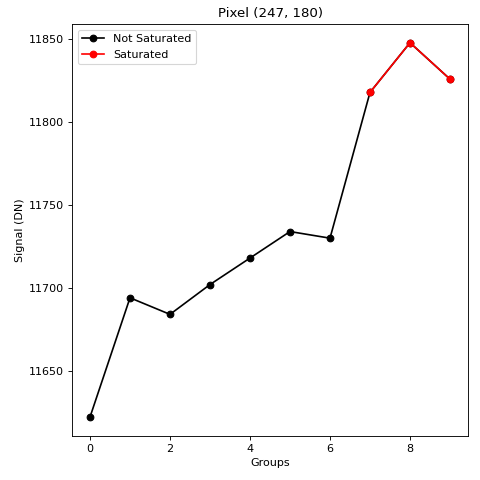

In [39]:
# Plot the pixel's values up the ramp and denote the saturated groups
plot_ramps(groups, full_ramp, saturated_points, label1='Not Saturated',
           label2='Saturated', title='Pixel ({}, {})'.format(x, y))

 <a id='superbias'> </a>
## The `Superbias Subtraction` step

#### Summary

This step subtracts the superbias reference frame from each group of the science exposure.

#### Documentation

[Full description](https://jwst-pipeline.readthedocs.io/en/stable/jwst/superbias/description.html) of the step.

#### Arguments

There are no optional arguments for this step

#### Reference files used

This step uses the [`SUPERBIAS`](https://jwst-pipeline.readthedocs.io/en/stable/jwst/superbias/reference_files.html) reference file. This file contains a map of the superbias signal in ADU for each pixel on the detector.


#### Run the step

Since we ran the step above and saved the outputs, we'll skip this part and just load the outputs. 

In [40]:
# # Using the run() method
# superbias_step = SuperBiasStep()
# superbias_step.output_dir = output_dir
# superbias_step.save_results = True

# # Call using the the output from the previously-run saturation step
# superbias = superbias_step.run(saturation)

In [41]:
#with datamodels.open(file_names[0].replace('uncal.fits', 'superbias.fits')) as superbias:
superbias = datamodels.open(file_names[0].replace('uncal.fits', 'superbias.fits'))    
print(superbias.info())

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 2.12.0
├─history (dict)
│ └─extensions (list) ...
├─_fits_hash (str): da9c8bc02290968ac961662c86cfd11895fec2b40da2dec676f32917dd961c73
├─data (ndarray): shape=(1, 10, 2048, 2048), dtype=float32
├─err (ndarray): shape=(1, 10, 2048, 2048), dtype=float32
├─extra_fits (dict)
│ └─PRIMARY (dict) ...
├─group (FITS_rec): shape=(10,), dtype=record784
├─groupdq (ndarray): shape=(1, 10, 2048, 2048), dtype=uint8
├─int_times (FITS_rec): shape=(1,), dtype=record416
├─meta (dict)
│ ├─aperture (dict) ...
│ ├─cal_step (dict) ...
│ ├─calibration_software_revision (str): RELEASE
│ └─19 not shown
├─pixeldq (ndarray): shape=(2048, 2048), dtype=uint32
└─zeroframe (ndarray): shape=(1, 2048, 2048), dtype=float32
Some nodes not shown.
None


Let's visually compare the science products to the raw `uncal` data, looking only at the last group of the first integration.

In [42]:
# Look at the shape of the data in the datamodel output from the step
superbias.data[0, 0, :, :].shape

(2048, 2048)

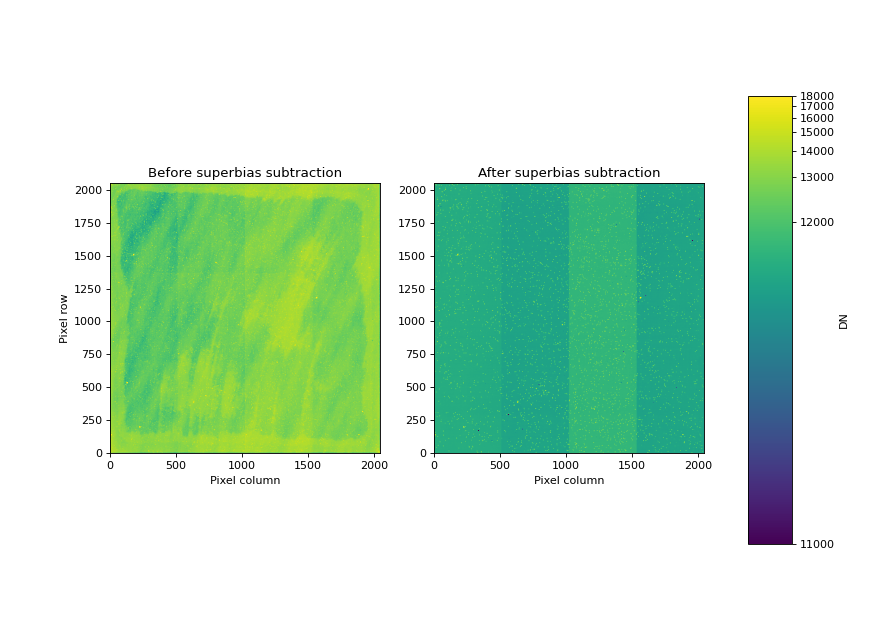

In [43]:
# Look at the data before and after superbias subtraction
side_by_side(saturation.data[0, 0, :, :], superbias.data[0, 0, :, :], vmin=11000, vmax=18000,
            title1='Before superbias subtraction', title2='After superbias subtraction')

[Top of Notebook](#title_ID)

<a id='refpix'></a>
## The `Reference Pixel Subtraction` step

#### Summary

This step uses the reference pixels, which are not sensitive to illumination, to subtract group- and amplifier-dependent signal originating in the readout electronics from the data. There are two distinct corrections that are applied here.

First, the rows of reference pixels on the top and bottom of the detector are used to subtract amplifier-dependent offsets from each group. Within a given amplifier, the mean value of all reference pixels in even numbered columns is subtracted from the science pixels in the even numbered columns. The same strategy is used for the odd numbered columns. 

The second part of the reference pixel subtraction step uses the reference pixels along the left and right sides of the detector to mitigate 1/f noise. This noise is visible in the data as horizontal banding that stretches across the entire detector. 

#### Documentation

[Full description](https://jwst-pipeline.readthedocs.io/en/stable/jwst/refpix/description.html) of the step.

#### Arguments

[Full details on the optional arguments](https://jwst-pipeline.readthedocs.io/en/stable/jwst/refpix/arguments.html).

#### Reference files used

This step does not use any reference files.


#### Run the step

In order to better show the effects from the 2 parts of the reference file subtraction, we're going to run this step twice. First we'll perform only the mean value subtraction using the top and bottom reference pixels. Then on the second run, we'll perform both the mean value subtraction and the 1/f subtraction.

<a id='refpix_run'></a>
##### Using the run() method

A reminder of the available parameters that can be set:

In [44]:
# Use the spec attribute to print available parameters
print(RefPixStep.spec)


        odd_even_columns = boolean(default=True)
        use_side_ref_pixels = boolean(default=True)
        side_smoothing_length = integer(default=11)
        side_gain = float(default=1.0)
        odd_even_rows = boolean(default=True)
    


In [45]:
# For this 'partial' run, we need to turn off the 1/f correction that
# uses the reference pixels on the sides of the detector. Also, we'll
# save the output using a unique name so as not to confuse the file
# with the output where we run the entire repix subtraction step.

refpix_step_no_sidepix = RefPixStep()
refpix_step_no_sidepix.save_results = True
refpix_step_no_sidepix.output_file = 'refpix_test_no_side_pixels'

# Turn off the 1/f correction
refpix_step_no_sidepix.use_side_ref_pixels = False

# Call using the the output from the previously-run superbias step
refpix_no_sidepix = refpix_step_no_sidepix.run(superbias)

2022-07-06 09:45:36,614 - stpipe.RefPixStep - INFO - RefPixStep instance created.


2022-07-06 09:45:36,863 - stpipe.RefPixStep - INFO - Step RefPixStep running with args (<RampModel(1, 10, 2048, 2048) from jw98765001001_01101_00003_nrcb5_superbias.fits>,).


2022-07-06 09:45:36,865 - stpipe.RefPixStep - INFO - Step RefPixStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp2fosez3c/refpix_test_no_side_pixels', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': False, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-07-06 09:45:37,073 - stpipe.RefPixStep - INFO - NIR full frame data


2022-07-06 09:45:37,074 - stpipe.RefPixStep - INFO - The following parameters are valid for this mode:


2022-07-06 09:45:37,075 - stpipe.RefPixStep - INFO - use_side_ref_pixels = False


2022-07-06 09:45:37,076 - stpipe.RefPixStep - INFO - odd_even_columns = True


2022-07-06 09:45:37,077 - stpipe.RefPixStep - INFO - side_smoothing_length = 11


2022-07-06 09:45:37,078 - stpipe.RefPixStep - INFO - side_gain = 1.0


2022-07-06 09:45:37,079 - stpipe.RefPixStep - INFO - The following parameter is not applicable and is ignored:


2022-07-06 09:45:37,079 - stpipe.RefPixStep - INFO - odd_even_rows = False


2022-07-06 09:45:37,734 - stpipe.RefPixStep - INFO - Saved model in refpix_test_no_side_pixels_refpixstep.fits


2022-07-06 09:45:37,737 - stpipe.RefPixStep - INFO - Step RefPixStep done


Next run the full correction. This will produce the output that we will feed into subsequent steps.

In [46]:
# Instantiate and set parameters
refpix_step = RefPixStep()
refpix_step.save_results = True

# Call using the saturation instance from the previously-run
# saturation step
refpix = refpix_step.run(superbias)

2022-07-06 09:45:37,754 - stpipe.RefPixStep - INFO - RefPixStep instance created.


2022-07-06 09:45:38,041 - stpipe.RefPixStep - INFO - Step RefPixStep running with args (<RampModel(1, 10, 2048, 2048) from jw98765001001_01101_00003_nrcb5_superbias.fits>,).


2022-07-06 09:45:38,043 - stpipe.RefPixStep - INFO - Step RefPixStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-07-06 09:45:38,262 - stpipe.RefPixStep - INFO - NIR full frame data


2022-07-06 09:45:38,263 - stpipe.RefPixStep - INFO - The following parameters are valid for this mode:


2022-07-06 09:45:38,264 - stpipe.RefPixStep - INFO - use_side_ref_pixels = True


2022-07-06 09:45:38,265 - stpipe.RefPixStep - INFO - odd_even_columns = True


2022-07-06 09:45:38,265 - stpipe.RefPixStep - INFO - side_smoothing_length = 11


2022-07-06 09:45:38,266 - stpipe.RefPixStep - INFO - side_gain = 1.0


2022-07-06 09:45:38,267 - stpipe.RefPixStep - INFO - The following parameter is not applicable and is ignored:


2022-07-06 09:45:38,267 - stpipe.RefPixStep - INFO - odd_even_rows = False


2022-07-06 09:45:42,029 - stpipe.RefPixStep - INFO - Saved model in jw98765001001_01101_00003_nrcb5_refpixstep.fits


2022-07-06 09:45:42,032 - stpipe.RefPixStep - INFO - Step RefPixStep done


#### Examine the output

Let's explore the output from this step. As with all NIR detectors, the outermost 4 rows and columns comprise the reference pixels.

Let's use the datamodels from before and after the reference pixel subtraction to have a look at the data. 

We'll zoom in on the top few rows in order to see the changes. Note how the "odd/even" effect dominates the signal prior to reference pixel subtraction. Even numbered columns and odd numbered columns have significantly different signal levels.

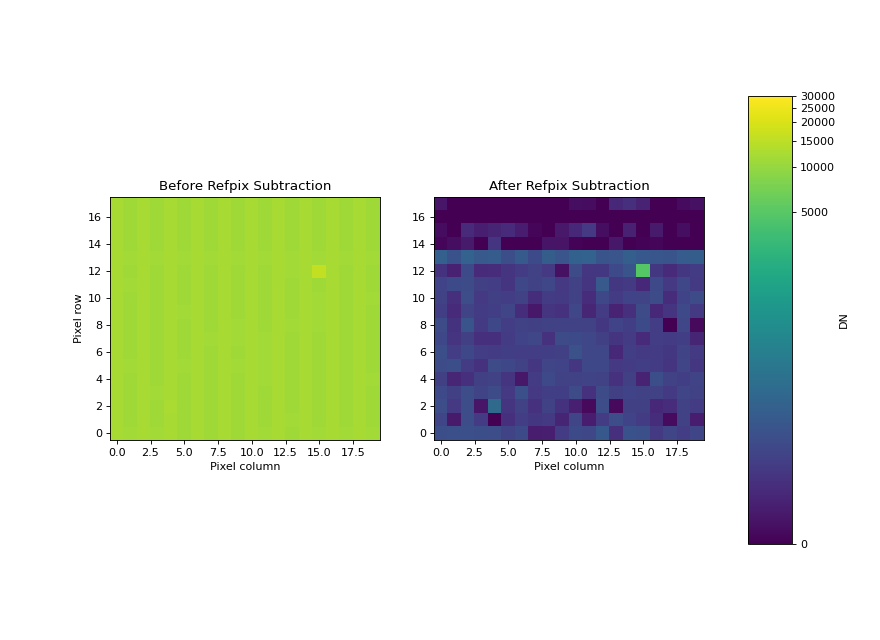

In [47]:
# Side by side, before/after reference pixel subtraction
side_by_side(superbias.data[0, 5, 2030:, 1030:1050], refpix.data[0, 5, 2030:, 1030:1050],
             vmin=0, vmax=30000, title1='Before Refpix Subtraction',
             title2='After Refpix Subtraction')

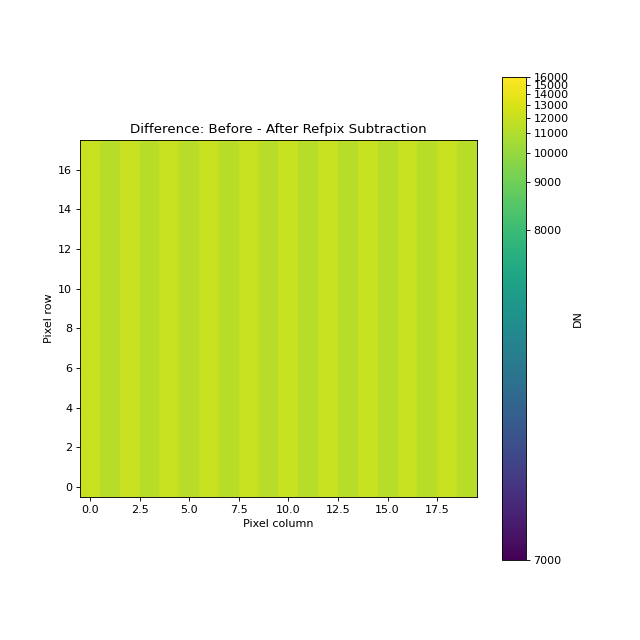

In [48]:
# Image of the difference before/after reference pixel subtraction
show_image(superbias.data[0, 5, 2030:, 1030:1050] - refpix.data[0, 5, 2030:, 1030:1050],
           vmin=7000, vmax=16000, title='Difference: Before - After Refpix Subtraction')

Now let's look at the difference in the data after the mean value subtraction compared to the case where both the mean value subtraction and the 1/f correction are done.

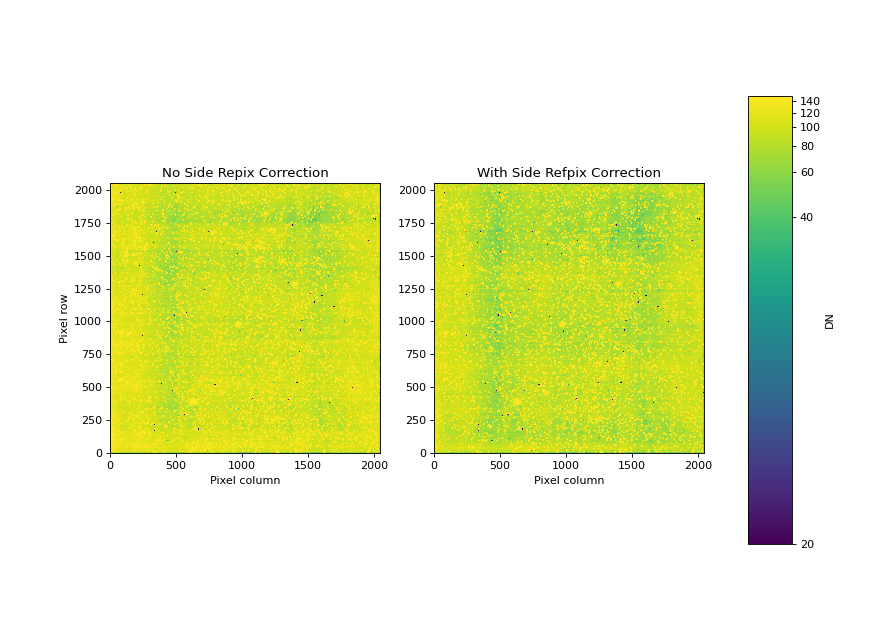

In [49]:
# Side by side view of the reference pixel subtraction with and without
# using the side reference pixels to subtract 1/f noise
side_by_side(refpix_no_sidepix.data[0, 5, :, :], refpix.data[0, 5, :, :],
             vmin=20, vmax=150, title1='No Side Repix Correction',
             title2='With Side Refpix Correction')

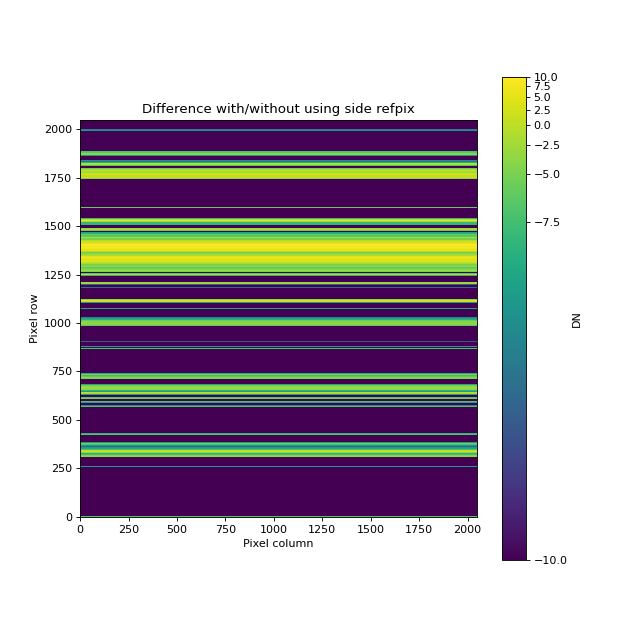

In [50]:
# Look at the difference image before and after the side reference
# pixels are used to subtract the 1/f noise
show_image(refpix.data[0, 5, :, :] - refpix_no_sidepix.data[0, 5, :, :],
           vmin=-10, vmax=10, title="Difference with/without using side refpix")

[Top of Notebook](#title_ID)

<a id='linearity'></a>
## The `Linearity Correction` step 

#### Summary

This step applies the classical linearity correction to the data on a pixel-by-pixel, integration-by-integration, group-by-group manner.

#### Documentation

[Full description](https://jwst-pipeline.readthedocs.io/en/stable/jwst/linearity/description.html) of the step.

#### Arguments

There are no optional arguments for this step

#### Reference files used

This step uses the [`LINEARITY`](https://jwst-pipeline.readthedocs.io/en/stable/jwst/linearity/reference_files.html) reference file. This file contains the polynomial coefficients used to apply the linearity correction to non-linear data.


#### Run the step

Since we ran the step above and saved the outputs, we'll skip this part and just load the outputs. 

In [51]:
# # Using the run() method
# linearity_step = LinearityStep()
# linearity_step.output_dir = output_dir
# linearity_step.save_results = True

# # Call using the refpix instance from the previously-run
# # refpix step
# linearity = linearity_step.run(refpix)

In [52]:
#with datamodels.open(file_names[0].replace('uncal.fits', 'linearity.fits')) as linearity:
linearity = datamodels.open(file_names[0].replace('uncal.fits', 'linearity.fits'))
print(linearity.info())

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 2.12.0
├─history (dict)
│ └─extensions (list) ...
├─_fits_hash (str): 9ed98d851bac43ebbaeab800289acee975546ef66b0abb5cb413741c95fee259
├─data (ndarray): shape=(1, 10, 2048, 2048), dtype=float32
├─err (ndarray): shape=(1, 10, 2048, 2048), dtype=float32
├─extra_fits (dict)
│ └─PRIMARY (dict) ...
├─group (FITS_rec): shape=(10,), dtype=record784
├─groupdq (ndarray): shape=(1, 10, 2048, 2048), dtype=uint8
├─int_times (FITS_rec): shape=(1,), dtype=record416
├─meta (dict)
│ ├─aperture (dict) ...
│ ├─cal_step (dict) ...
│ ├─calibration_software_revision (str): RELEASE
│ └─19 not shown
├─pixeldq (ndarray): shape=(2048, 2048), dtype=uint32
└─zeroframe (ndarray): shape=(1, 2048, 2048), dtype=float32
Some nodes not shown.
None


#### Examine the output

Let's look at the signal up the ramp for a high signal pixel, in order to more easily see how the linearity correction changed the data.

In [53]:
# Using the 3rd group, find the difference between the data before and after
# linearity correction. Find the pixels where this difference is greater than
# 20 DN, and also where the signal in the final group is over 40,000 DN.
lin_fix = linearity.data[0, 3, :, :] - refpix.data[0, 3, :, :]
well_exposed = np.where((linearity.data[0, -1, :, :] > 40000.) & (lin_fix > 20))

In [54]:
print('{} pixels meet the criteria above.'.format(len(well_exposed[0])))

9 pixels meet the criteria above.


Pick one of these pixels and plot the signal before and after the linearity correction.

In [55]:
index = 3
lin_pix_x, lin_pix_y = (well_exposed[1][index], well_exposed[0][index])

In [56]:
# Create an array of group numbers to plot against
group_nums = np.arange(10)

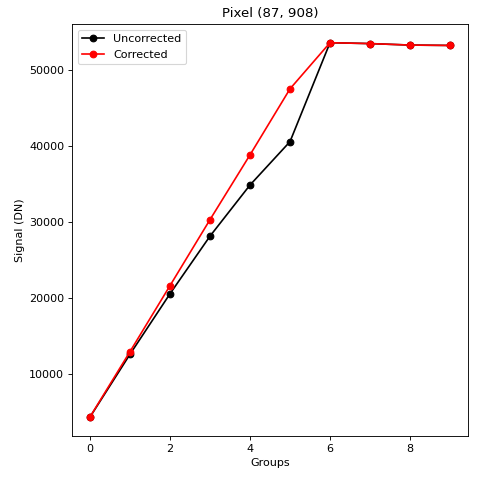

In [57]:
plot_ramps(group_nums, refpix.data[0, :, lin_pix_y, lin_pix_x],
           linearity.data[0, :, lin_pix_y, lin_pix_x], label1='Uncorrected', label2='Corrected',
           title='Pixel ({}, {})'.format(lin_pix_x, lin_pix_y))

In this case, the pixel reached saturation in group 9. So in group 9, the linearity correction made no changes. Between groups 0 to 8, you can see the original signal (in black) becoming more and more non-linear as signal increases, along with how the linearity correction modified the signal (red).

[Top of Notebook](#title_ID)

<a id='persistence'></a>
## The `Persistence Correction` step 

#### Summary

This step uses a model to calculate the amount of signal in each group of each pixel that comes from persistence. This persistence signal is then subtracted, pixel-by-pixel and group-by-group, from the data.

#### Documentation

[Full description](https://jwst-pipeline.readthedocs.io/en/stable/jwst/persistence/description.html) of the step.

#### Arguments

[Optional arguments](https://jwst-pipeline.readthedocs.io/en/stable/jwst/persistence/arguments.html) for this step include setting the threshold signal value above which pixels are flagged in the DQ extension, as well as saving the subtracted persistence signal in a separate file.

#### Reference files used

This step uses the [`TRAPDENSITY`, `PERSAT`, and `TRAPPARS`](https://jwst-pipeline.readthedocs.io/en/stable/jwst/persistence/reference_files.html) reference files. The TRAPDENSITY file contains a map of the relative number of traps per pixel. The PERSAT reference file contains a map of the persistence saturation level, and the TRAPPARS reference file contains parameters related to the persistence calculation model. 

#### Run the step

**Note: this is skipped for now. Test will be added later.**

In [58]:
print(PersistenceStep.spec)


        # `input_trapsfilled` is the name of the most recent trapsfilled
        # file for the current detector.
        input_trapsfilled = string(default="")
        # Pixels that have received a persistence correction greater than
        # or equal to `flag_pers_cutoff` DN will be flagged in the pixeldq
        # extension of the output (rootname_persistence.fits) file.
        flag_pers_cutoff = float(default=40.)
        # if `save_persistence` is True, the persistence that was
        # subtracted (group by group, integration by integration) will be
        # written to an output file with suffix "_output_pers".
        save_persistence = boolean(default=False)
        # If `save_trapsfilled` is True, the updated trapsfilled file will
        # be written to an output file with suffix "_trapsfilled".
        save_trapsfilled = boolean(default=True)
    


In [59]:
# # Using the run() method
# persist_step = PersistenceStep()
# persist_step.output_dir = output_dir
# persist_step.save_results = True

# # Specify the trapsfilled file, which contains the
# # state of the charge traps in the preceding exposure
# persist_step.input_trapsfilled = persist_file

# # Let's also save a separate file that contains the
# # subtracted persistence signal 
# persist_step.save_persistence = True

# # Call using the refpix instance from the previously-run
# # linearity step
# persist = persist_step.run(linearity)

#### Examine the output

Let's look at the optional output file that contains the subtracted persistence signal. 

NOTE: In this case the output is pretty boring. It turns out that the trap density map reference file for NIRCam is empty because it is not yet well characterized. This means that the persistence signal is zero in all pixels for all exposures. Once the map is updated in commissioning, this step will start calculating persistence values.

In [60]:
# # Name of the file containing a map of the calculated persistence signal
# persist_signal_file = os.path.join(output_dir, '{}output_pers.fits'.format(input_file_base))

In [61]:
# # Read in the map of persistence signal
# persist_signal = fits.getdata(persist_signal_file)

The file contains the persistence signal for each group of each integration, as we can see by the shape.

In [62]:
# persist_signal.shape

In [63]:
# np.min(persist_signal), np.max(persist_signal)

Let's look at the persistence signal in the final group.

In [64]:
# show_image(persist_signal[0, -1, :, :], 0, .01)

<a id='dc'></a>
##  The `Dark Current Subtraction` step 

#### Summary

This step subtracts the dark current, group by group, from the input integrations.

#### Documentation

[Full description](https://jwst-pipeline.readthedocs.io/en/stable/jwst/dark_current/description.html) of the step.

#### Arguments

There are no optional arguments for this step

#### Reference files used

This step uses the [`DARK`](https://jwst-pipeline.readthedocs.io/en/stable/jwst/dark_current/reference_files.html) reference file. This file contains the measured mean dark current associated with the detector and subarray.


#### Run the step

NOTE: This is one of the longer-running steps of calwebb_detector1. 

Since we ran the step above and saved the outputs, we'll skip this part and just load the outputs. 

In [65]:
# # Using the run() method
# dark_step = DarkCurrentStep()
# dark_step.save_results = True

# # Call using the persistence instance from the previously-run
# # persistence step
# dark = dark_step.run(linearity)

In [66]:
#with datamodels.open(file_names[0].replace('uncal.fits', 'dark_current.fits')) as dark:
dark = datamodels.open(file_names[0].replace('uncal.fits', 'dark_current.fits')) 
print(dark.info())

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 2.12.0
├─history (dict)
│ └─extensions (list) ...
├─_fits_hash (str): 503608c3b61ee6cfe824280a4ab076a7639c364698d4e8bf0e0c7f229012b651
├─data (ndarray): shape=(1, 10, 2048, 2048), dtype=float32
├─err (ndarray): shape=(1, 10, 2048, 2048), dtype=float32
├─extra_fits (dict)
│ └─PRIMARY (dict) ...
├─group (FITS_rec): shape=(10,), dtype=record784
├─groupdq (ndarray): shape=(1, 10, 2048, 2048), dtype=uint8
├─int_times (FITS_rec): shape=(1,), dtype=record416
├─meta (dict)
│ ├─aperture (dict) ...
│ ├─cal_step (dict) ...
│ ├─calibration_software_revision (str): RELEASE
│ └─19 not shown
├─pixeldq (ndarray): shape=(2048, 2048), dtype=uint32
└─zeroframe (ndarray): shape=(1, 2048, 2048), dtype=float32
Some nodes not shown.
None


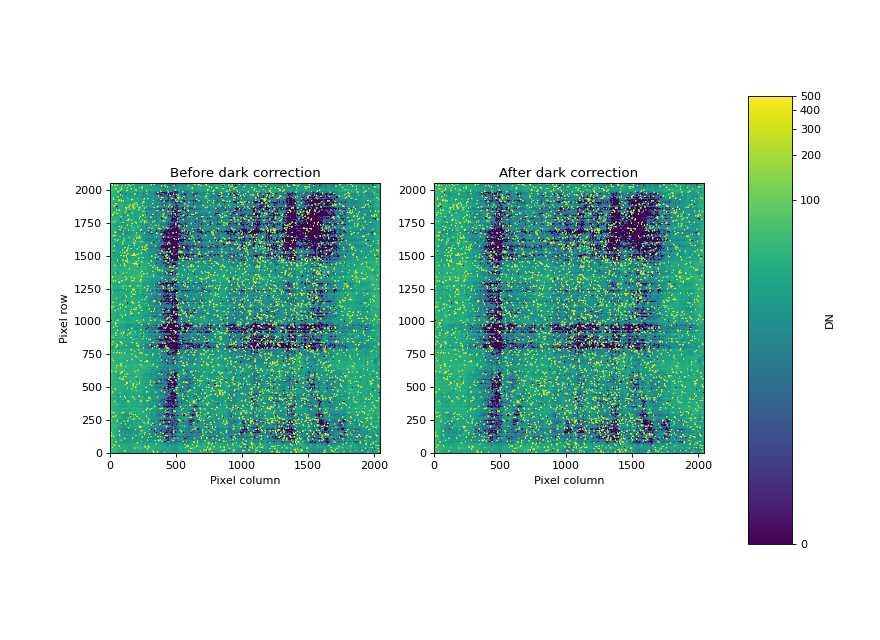

In [67]:
# Look at the data before and after superbias subtraction
side_by_side(linearity.data[0, 0, :, :], dark.data[0, 0, :, :], vmin=0, vmax=500,
            title1='Before dark correction', title2='After dark correction')

[Top of Notebook](#title_ID)

<a id='jump'></a>
## The `Cosmic Ray Flagging` step

#### Summary

This step searches for "jumps" in the ramp data. In this case, a jump in a pixel's ramp is defined as a large deviation in the count rate relative to that in the other groups. When a jump is found, the associated flag is added to the `GROUPDQ` extension for the group and pixel where the jump was detected. The science data are not modified at all. In the subsequent ramp-fitting step, the algorithm will look into the `GROUPDQ` array and ignore any groups where the jump flag has been set.

#### Documentation

[Full description](https://jwst-pipeline.readthedocs.io/en/stable/jwst/jump/description.html) of the step.

#### Arguments

The jump step has [several optional arguments](https://jwst-pipeline.readthedocs.io/en/stable/jwst/jump/arguments.html)

#### Reference files used

This step uses the [`READNOISE`](https://jwst-pipeline.readthedocs.io/en/stable/jwst/references_general/readnoise_reffile.html) and [`GAIN`](https://jwst-pipeline.readthedocs.io/en/stable/jwst/references_general/gain_reffile.html) reference files. These files contain maps of the readnoise and gain values across the detector.


#### Run the step

Since we ran the step above and saved the outputs, we'll skip this part and just load the outputs. 

List the available parameters:

In [68]:
print(JumpStep.spec)


        rejection_threshold = float(default=4.0,min=0) # CR sigma rejection threshold
        three_group_rejection_threshold = float(default=6.0,min=0) # CR sigma rejection threshold
        four_group_rejection_threshold = float(default=5.0,min=0) # CR sigma rejection threshold
        maximum_cores = option('none', 'quarter', 'half', 'all', default='none') # max number of processes to create
        flag_4_neighbors = boolean(default=True) # flag the four perpendicular neighbors of each CR
        max_jump_to_flag_neighbors = float(default=1000) # maximum jump sigma that will trigger neighbor flagging
        min_jump_to_flag_neighbors = float(default=10) # minimum jump sigma that will trigger neighbor flagging
    


In [69]:
# # Using the run() method
# jump_step = JumpStep()
# jump_step.output_dir = output_dir
# jump_step.save_results = True
# jump_step.rejection_threshold = 9

# # Call using the dark instance from the previously-run
# # dark current subtraction step
# jump = jump_step.run(dark)

In [70]:
#with datamodels.open(file_names[0].replace('uncal.fits', 'jump.fits')) as jump:
jump = datamodels.open(file_names[0].replace('uncal.fits', 'jump.fits'))
print(jump.info())

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 2.12.0
├─history (dict)
│ └─extensions (list) ...
├─_fits_hash (str): 339cfd94094d363ec1ff42bdedda96f893f5c642d4271687dea0d5c32df0107e
├─data (ndarray): shape=(1, 10, 2048, 2048), dtype=float32
├─err (ndarray): shape=(1, 10, 2048, 2048), dtype=float32
├─extra_fits (dict)
│ └─PRIMARY (dict) ...
├─group (FITS_rec): shape=(10,), dtype=record784
├─groupdq (ndarray): shape=(1, 10, 2048, 2048), dtype=uint8
├─int_times (FITS_rec): shape=(1,), dtype=record416
├─meta (dict)
│ ├─aperture (dict) ...
│ ├─cal_step (dict) ...
│ ├─calibration_software_revision (str): RELEASE
│ └─19 not shown
├─pixeldq (ndarray): shape=(2048, 2048), dtype=uint32
└─zeroframe (ndarray): shape=(1, 2048, 2048), dtype=float32
Some nodes not shown.
None


#### Examine the output

Let's see what some of these jumps look like:

In [71]:
# How many total jump flags were added? Note that some pixels
# will have more than one group flagged with a jump.
jump_flags = np.where(jump.groupdq & dqflags.pixel['JUMP_DET'] > 0)
print('{} jump flags detected.'.format(len(jump_flags[0])))

# Create a 4-dimensional map of the jump flags
jump_map = (jump.groupdq & dqflags.pixel['JUMP_DET'] > 0)

# Collapse down to a 2D map of the number of flagged jumps in each pixel
jump_map_2d = np.sum(jump_map[0, :, :, :], axis=0)

# Determine how many pixels have jump flags
jump_map_indexes = np.where(jump_map_2d > 0)
impacted_pix = np.sum(jump_map_2d > 0)
total_pix = 2048 * 2048
print(('{} pixels ({:.2f}% of the detector) have been flagged with '
      'at least one jump.'.format(impacted_pix, 100. * impacted_pix / total_pix)))

116794 jump flags detected.


77869 pixels (1.86% of the detector) have been flagged with at least one jump.


Plot some of the pixels impacted by jumps. The red marks signify flagged jumps. These signal values will be ignored in subsequent ramp-fitting.

In [72]:
# The jump map is 4-dimensional, just like the science data
jump_map.shape

(1, 10, 2048, 2048)

In [73]:
# Create an array of group numbers to plot against
group_indexes = np.arange(jump_map.shape[1]).astype(int)

In [74]:
# Pick one pixel with a flagged jump, and find the group(s) with the jump flags
j_index = 10112
jumpy = jump_map_indexes[0][j_index]
jumpx = jump_map_indexes[1][j_index]
jump_grp = jump_map[0, :, jumpy, jumpx]
print('Jump located in group(s) {} of pixel ({}, {})'.format(group_indexes[jump_grp], jumpx, jumpy))

Jump located in group(s) [2] of pixel (968, 255)


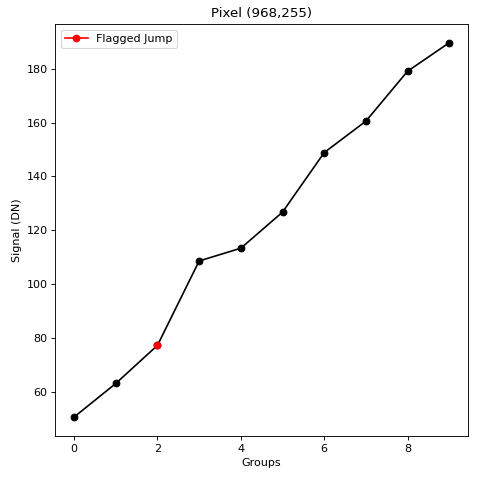

In [75]:
# Plot the signal up the ramp for this pixel
plot_jump(jump.data[0, :, jumpy, jumpx], jump_grp, xpixel=jumpx, ypixel=jumpy)

Plot a grid of some examples of flagged jumps. The red marks signify flagged jumps. These signal values will be ignored in subsequent ramp-fitting.

In [76]:
indexes_to_plot = [200, 401, 600, 30010, 31000, 1202, 1400, 21600, 10112]
jump_data = np.zeros((jump.shape[1], len(indexes_to_plot)))
jump_grps = np.zeros((jump.shape[1], len(indexes_to_plot))).astype(bool)
jump_locs = []
for counter, idx in enumerate(indexes_to_plot):
    #integ, grp, y, x = jump_flags[idx]
    y = jump_map_indexes[0][idx]
    x = jump_map_indexes[1][idx]
    grp = jump_map[0, :, y, x]

    jump_data[:, counter] = jump.data[0, :, y, x]
    jump_grps[:, counter] = grp
    jump_locs.append((x, y))

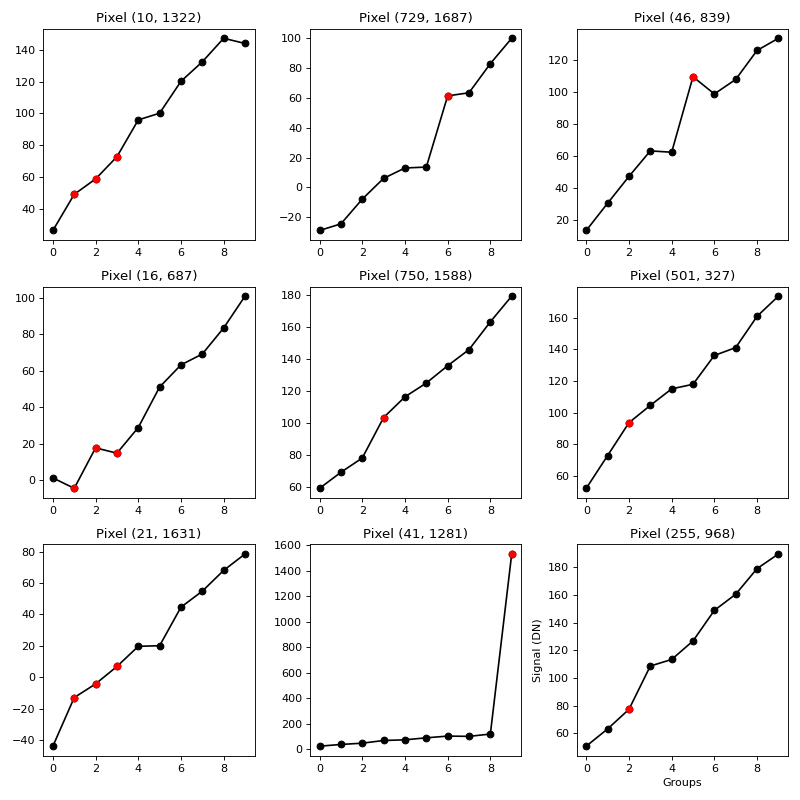

In [77]:
plot_jumps(jump_data, jump_grps, jump_locs)

[Top of Notebook](#title_ID)

<a id='ramp_fitting'></a>
## The `Ramp Fitting` step

#### Summary

This step performs line-fitting to the corrected data, and produces a slope image for each integration. For a given pixel, any groups within an integration that contain a jump flag or that are flagged as saturated are ignored.

For the purposes of this notebook, we will use the `save_opt` parameter to tell the ramp-fitting step to save an optional output file that contains some of the details on the ramp fits. This information will be used for the plots after the step is run. By default, `save_opt` is False and the optional outputs are not saved.


#### Documentation

[Full description](https://jwst-pipeline.readthedocs.io/en/stable/jwst/ramp_fitting/description.html) of the step.

#### Arguments

The jump step has [several optional arguments](https://jwst-pipeline.readthedocs.io/en/stable/jwst/ramp_fitting/arguments.html), including the ability to save optional outputs into a second file.

#### Reference files used

This step uses the [`READNOISE`](https://jwst-pipeline.readthedocs.io/en/stable/jwst/references_general/readnoise_reffile.html) and [`GAIN`](https://jwst-pipeline.readthedocs.io/en/stable/jwst/references_general/gain_reffile.html) reference files. These files contain maps of the readnoise and gain values across the detector.


#### Run the step

Since we ran the step above and saved the outputs, we'll skip this part and just load the outputs. 

List the available parameters:

In [78]:
print(RampFitStep.spec)


        int_name = string(default='')
        save_opt = boolean(default=False) # Save optional output
        opt_name = string(default='')
        suppress_one_group = boolean(default=True)  # Suppress saturated ramps with good 0th group
        maximum_cores = option('none', 'quarter', 'half', 'all', default='none') # max number of processes to create
    


In [79]:
# # Using the run() method
# ramp_fit_step = RampFitStep()
# ramp_fit_step.save_results = True

# # Let's save the optional outputs, in order
# # to help with visualization later
# ramp_fit_step.save_opt = True

# # Call using the dark instance from the previously-run
# # jump step
# ramp_fit = ramp_fit_step.run(jump)

In [80]:
ramp_fit = datamodels.open(file_names[0].replace('uncal.fits', '0_ramp_fit.fits')), datamodels.open(file_names[0].replace('uncal.fits', '1_ramp_fit.fits'))  

An important detail here is that there are two output files: 

1. The file ending with `*_0_rampfitstep.fits` contains the mean slope image across all integrations in the exposure.

2. The file ending with `*_1_rampfitstep.fits` contains a separate slope image for each integration. In this case our exposure contains only a single integration, so the data in the two files are identical.

We are working with the output datamodels in this notebook. Unlike the preceeding steps, where the output was a single datamodel, the ramp_fitting step outputs a tuple of 2 datamodel instances. The first element in the tuple is the datamodel instance containing the mean rate image, while the second element is the datamodel instance containing a separate slope image for each integration.

In [81]:
type(ramp_fit)

tuple

In [82]:
type(ramp_fit[0]), type(ramp_fit[1])

(jwst.datamodels.image.ImageModel, jwst.datamodels.cube.CubeModel)

Show the shape of the two output data models. The output with the mean slope image is only 2-dimensional, while the output with one slope image for each integration is 3-dimensional, even in this case where we have only one integration.

In [83]:
ramp_fit[0].shape, ramp_fit[1].shape

((2048, 2048), (1, 2048, 2048))

Here we see that in our case with a single integration, the two datamodel instances contain identical data.

In [84]:
ramp_fit[0].data[500, 500], ramp_fit[1].data[0, 500, 500]

(0.5302285, 0.5302285)

And note that the data in these files are the slopes from the ramp fitting, so the units have changed from DN to DN/sec.

In [85]:
# Show the units of the ramp-fit data
ramp_fit[0].meta.bunit_data

'DN/s'

Let's load the data from the third output file, which contains the optional outputs. Our goal is to grab the intercept values from the line-fitting and use them to re-create the plots from the jump step and overplot the best-fit signals on top of the signals that went into the step.

In [86]:
# Generate the name of the optional output file
optional_file = file_names[0].replace('uncal.fits', 'fitopt.fits')

In [87]:
# Open the file and examine the extensions
hdulist = fits.open(optional_file)
hdulist.info()

Filename: jw98765001001_01101_00003_nrcb5_fitopt.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     166   ()      
  1  SLOPE         1 ImageHDU        11   (2048, 2048, 5, 1)   float32   
  2  SIGSLOPE      1 ImageHDU        11   (2048, 2048, 5, 1)   float32   
  3  VAR_POISSON    1 ImageHDU        11   (2048, 2048, 5, 1)   float32   
  4  VAR_RNOISE    1 ImageHDU        11   (2048, 2048, 5, 1)   float32   
  5  YINT          1 ImageHDU        11   (2048, 2048, 5, 1)   float32   
  6  SIGYINT       1 ImageHDU        11   (2048, 2048, 5, 1)   float32   
  7  PEDESTAL      1 ImageHDU        10   (2048, 2048, 1)   float32   
  8  WEIGHTS       1 ImageHDU        11   (2048, 2048, 5, 1)   float32   
  9  CRMAG         1 ImageHDU        11   (2048, 2048, 8, 1)   float32   
 10  ASDF          1 BinTableHDU     11   1R x 1C   [4896B]   


The intercepts from the line-fitting are stored in the `YINT` extension.

In [88]:
hdulist['YINT'].data[0, :, 200, 200]

array([86.64458,  0.     ,  0.     ,  0.     ,  0.     ], dtype=float32)

For our plots below, we need the intercept values from the line-fitting. Let's ignore all but the first plane of the extension, since those are zeros.

In [89]:
intercepts = hdulist['YINT'].data[0, 0, :, :]
hdulist.close()

For the pixels to be plotted, create linear ramps using the output slopes and intercepts

In [90]:
# Get the exposure time associated with each group
num_groups = ramp_fit[0].meta.exposure.ngroups
group_time = ramp_fit[0].meta.exposure.group_time
group_times = np.arange(num_groups) * group_time

In [91]:
# Reconstruct linear ramps from the slope and intercept values
lin_ramps = np.zeros((jump.shape[1], len(indexes_to_plot)))
for counter, idx in enumerate(indexes_to_plot):
    y = jump_map_indexes[0][idx]
    x = jump_map_indexes[1][idx]
    grp = jump_map[0, :, y, x]

    rate = ramp_fit[0].data[y, x]
    intercept = intercepts[y, x]
    lin_ramps[:, counter] = intercept + (rate * group_times)    

In [92]:
# Reconstruct the linear ramp for the single pixel we showed after the jump step
lin_data = intercepts[jumpy, jumpx] + (ramp_fit[0].data[jumpy, jumpx] * group_times)

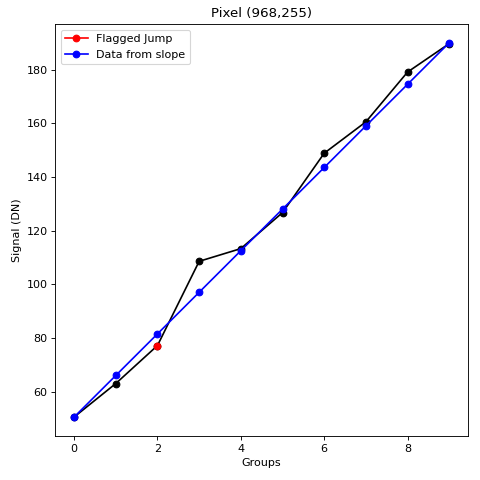

In [93]:
# Plot again the single pixel from the jump step, along with its
# reconstructed best-fit linear fit
plot_jump(jump.data[0, :, jumpy, jumpx], jump_grp, xpixel=jumpx,
          ypixel=jumpy, slope=lin_data)

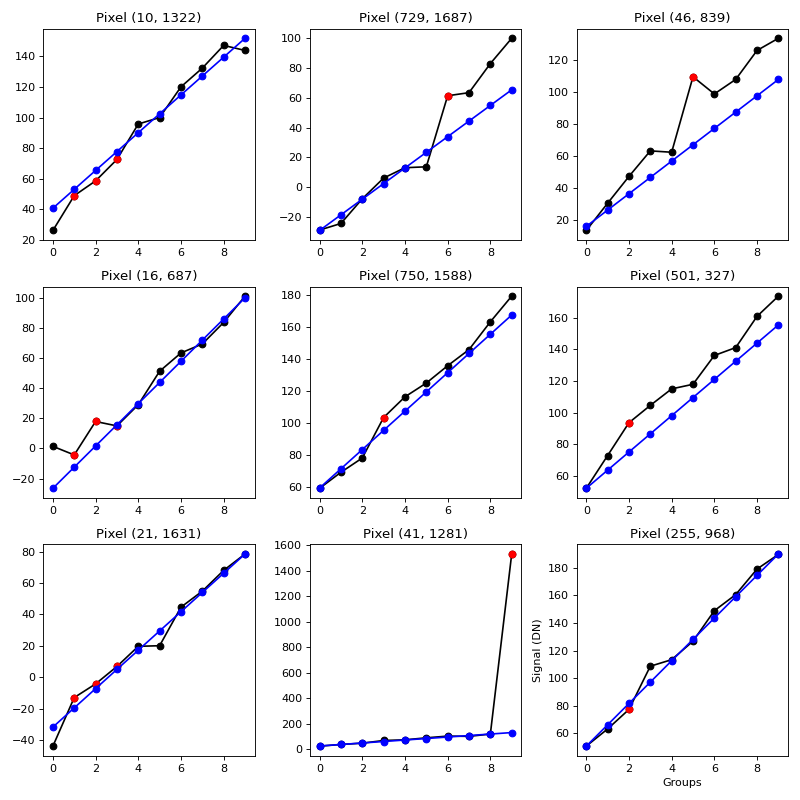

In [94]:
# Plot the same as above, but for the collection of pixels
# we plotted after the jump step
plot_jumps(jump_data, jump_grps, jump_locs, slopes=lin_ramps)

Look at the slope image. 

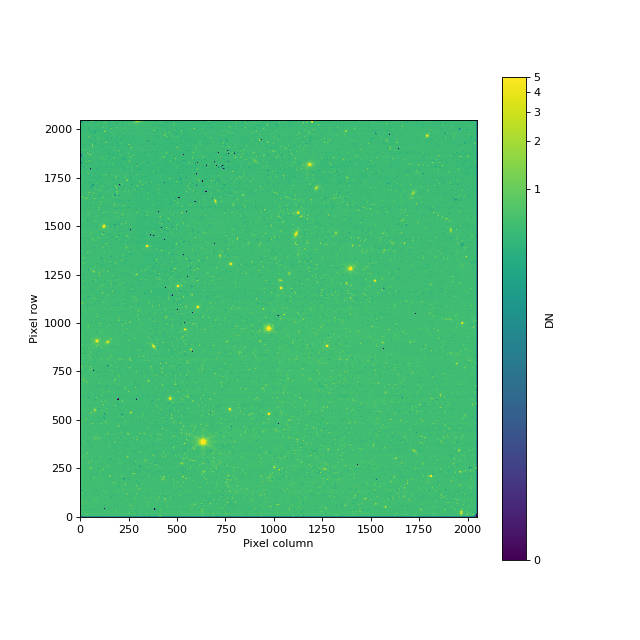

In [95]:
show_image(ramp_fit[0].data, 0, 5)

What's going on with the dark pixels scattered across the left side of the detector? It turns out they have signal values of exactly zero in the slope image. Let's have a closer look, and ignore the reference pixels.

In [96]:
scipix = ramp_fit[0].data[4:2044, 4:2044]
zero_pix = np.where(scipix == 0.0)
print('{} science pixels have a slope that is exactly zero.'.format(len(zero_pix[0])))

40855 science pixels have a slope that is exactly zero.


Pick one of these pixels, and examine the pixel's signals up the ramp, as well as its data quality flags up the ramp.

In [97]:
idx = 45

# Add 4 to the coordinates because we stripped off the 4 columns/rows of 
# refpix in the np.where statement above
y = 4 + zero_pix[0][idx]
x = 4 + zero_pix[1][idx]
print('({}, {}) has a slope of 0.'.format(x, y))

(2038, 5) has a slope of 0.


Print the slope (should be zero), signal values up the ramp, and DQ flags up the ramp

In [98]:
scipix[y-4, x-4]

0.0

In [99]:
linearity.data[0, :, y, x]

array([106.60889, 128.63126, 125.62926, 150.8748 , 148.35555, 161.74467,
       190.31221, 203.75983, 202.59193, 224.81302], dtype=float32)

In [100]:
linearity.groupdq[0, :, y, x]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=uint8)

What does a DQ flag value of 2 mean?

In [101]:
# Print JWST bad pixel flag definitions
dqflags.pixel

{'GOOD': 0,
 'DO_NOT_USE': 1,
 'SATURATED': 2,
 'JUMP_DET': 4,
 'DROPOUT': 8,
 'OUTLIER': 16,
 'PERSISTENCE': 32,
 'AD_FLOOR': 64,
 'RESERVED_4': 128,
 'UNRELIABLE_ERROR': 256,
 'NON_SCIENCE': 512,
 'DEAD': 1024,
 'HOT': 2048,
 'WARM': 4096,
 'LOW_QE': 8192,
 'RC': 16384,
 'TELEGRAPH': 32768,
 'NONLINEAR': 65536,
 'BAD_REF_PIXEL': 131072,
 'NO_FLAT_FIELD': 262144,
 'NO_GAIN_VALUE': 524288,
 'NO_LIN_CORR': 1048576,
 'NO_SAT_CHECK': 2097152,
 'UNRELIABLE_BIAS': 4194304,
 'UNRELIABLE_DARK': 8388608,
 'UNRELIABLE_SLOPE': 16777216,
 'UNRELIABLE_FLAT': 33554432,
 'OPEN': 67108864,
 'ADJ_OPEN': 134217728,
 'UNRELIABLE_RESET': 268435456,
 'MSA_FAILED_OPEN': 536870912,
 'OTHER_BAD_PIXEL': 1073741824,
 'REFERENCE_PIXEL': 2147483648}

So this pixel (and the others with values of 0 in the slope image) have been flagged as saturated in all groups. In this case, the pipeline cannot calculate a slope value, and assigns a value of zero. 

[Top of Notebook](#title_ID)

<a id="about_ID"></a>
## About this Notebook
**Original Author:** Bryan Hilbert, updated by Alicia Canipe, NIRCam
<br>**Updated On:** 07/28/2021

[Top of Notebook](#title_ID)